# Name: Anthony Gillioz 

# Assignment 2 ATML 2019
## CIFAR-10 classification with limited data
CIFAR-10 is a dataset with 10 image classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). https://www.cs.toronto.edu/~kriz/cifar.html  
We'll be working on a subset of the dataset (10k images, 1k per class, 32x32 pixels, RGB) and train a model to classify an image into one of the 10 classes.  
You may want to plot some images to get a better understanding what the data looks like (not credited).  
Loading data is implemented:  

In [27]:
from datasets import CIFAR10Limited
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, RandomAffine

# Basic transforms - you may need to change them
transforms = {'train': Compose([RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(1.0, 1.2), shear=5),
                                RandomHorizontalFlip(),
                                ColorJitter(0.2, 0.4),
                                ToTensor(),
                                Normalize(mean=(0.5, 0.5, 0.5),
                                          std=(0.5, 0.5, 0.5))]),
               'val': Compose([ToTensor(),
                              Normalize(mean=(0.5, 0.5, 0.5),
                                        std=(0.5, 0.5, 0.5))])}


train_dataset = CIFAR10Limited('cifar_data', split='train', transform=transforms['train'], download=True)
val_dataset = CIFAR10Limited('cifar_data', split='val', transform=transforms['val'], download=True)
test_dataset = CIFAR10Limited('cifar_data', split='test', transform=transforms['val'], download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Train a multilayer perceptron model (MLP) 

## 1. Train a model from MLPModel class, without any regularization. Use ADAM optimizer with default parameters to train for 25 epochs; optimize cross entropy loss. Note final accuracy and validation loss. Is the model overfitting? Why? 

In [0]:
import torch.nn as nn
    
class MLPModel(nn.Module):
    
    def __init__(self):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(nn.Linear(32*32*3, 128),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(128, 10))
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [0]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from itertools import product
from torch.utils.data import DataLoader
from train_tools import TrainHelper

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 64,
          'shuffle': True}

train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

In [0]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [0]:
def plot_stats(stats_training):
    train_loss, val_loss, train_acc, val_acc, nb_epochs = stats_training
    plot_graph(nb_epochs, train_loss, val_loss, "Loss")
    plot_graph(nb_epochs, train_acc, val_acc, "Accuracy")

Train_loss: 1.590 |                Val_loss: 1.559 |                Train_acc: 44.270 |                Val_acc: 45.680


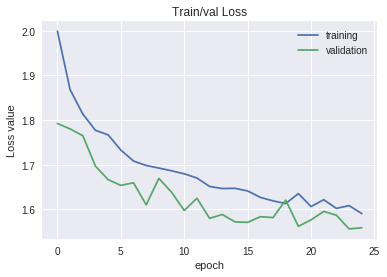

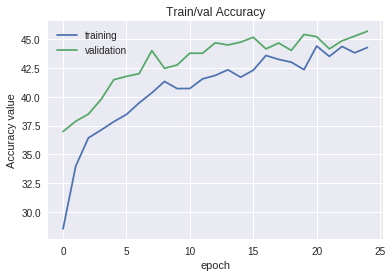

In [13]:
nb_epochs = 25
trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

neural_net = MLPModel()
neural_net.to(device)

optimizer = torch.optim.Adam(neural_net.parameters())
loss_function = nn.CrossEntropyLoss()
    
stats_training = trainer.fit(neural_net,
                             train_loader,
                             val_loader,
                             optimizer,
                             loss_function)
plot_stats(stats_training)

MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 2. Improve the model to get at least 46.5% accuracy on validation set in at most 25 epochs of training.
### For example: you can tweak the parameters (e.g. learning rate, batch size), the model (e.g. number of layers, number of units, activation function), add regularization (e.g. data augmentation, dropout, weight decay, early stopping).
### Note all the parameters and results on validation set for at least 4 settings that you tried (including the best one)
### You can get extra points for accuracy above 46.5%.

In [0]:
class ImprovedMLPModel(nn.Module):
    
    def __init__(self, drop_rate):
        super(ImprovedMLPModel, self).__init__()
        self.layers = nn.Sequential(nn.Linear(32*32*3, 512),
                                    nn.Dropout(drop_rate),
                                    nn.ReLU(),
                                    nn.Linear(512, 512),
                                    nn.Dropout(drop_rate),
                                    nn.ReLU(),
                                    nn.Linear(512, 128),
                                    nn.Dropout(drop_rate),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.Dropout(drop_rate),
                                    nn.ReLU(),
                                    nn.Linear(64, 10))
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        #print(input.shape)
        return self.layers(input)

Dropout rate: 0.0, Learning rate 5e-05, Weight decay 5e-05, optimizer RMSprop
Train_loss: 1.139 |                Val_loss: 1.446 |                Train_acc: 59.900 |                Val_acc: 50.670
Dropout rate: 0.0, Learning rate 5e-05, Weight decay 5e-05, optimizer Adam
Train_loss: 1.547 |                Val_loss: 1.571 |                Train_acc: 44.960 |                Val_acc: 44.780
Dropout rate: 0.0, Learning rate 5e-05, Weight decay 0.0001, optimizer RMSprop
Train_loss: 1.126 |                Val_loss: 1.444 |                Train_acc: 61.110 |                Val_acc: 50.570
Dropout rate: 0.0, Learning rate 5e-05, Weight decay 0.0001, optimizer Adam
Train_loss: 1.534 |                Val_loss: 1.563 |                Train_acc: 45.700 |                Val_acc: 45.320
Dropout rate: 0.0, Learning rate 0.0005, Weight decay 5e-05, optimizer RMSprop
Train_loss: 1.865 |                Val_loss: 1.869 |                Train_acc: 30.330 |                Val_acc: 31.950
Dropout rate: 0.0,

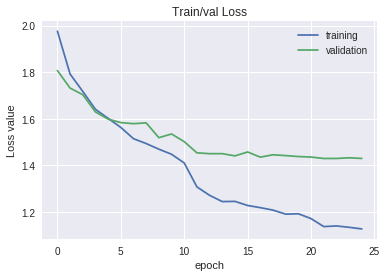

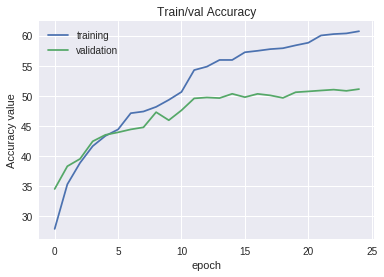

In [44]:
from copy import deepcopy
nb_epochs = 25
trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

hyperparameters = {"drop_rate": [0.0, 0.1, 0.15],
                   "lr": [0.00005, 0.0005], 
                   "weight_decay": [0.00005, 0.0001], 
                   "optimizer": [(torch.optim.RMSprop, 0.9), (torch.optim.Adam, None)]
                   }

# best parameters: (validation acc, drop_rate, statistic of the training)
best_parameters = (float("-INF"), None, None, None, None, None)

# keep a copy of the best trained network
best_model = None

debug = False

loss_function = nn.CrossEntropyLoss()

for drop_rate, l_rate, w_decay, opt_func in product(*hyperparameters.values()):
    improved_neural_net = ImprovedMLPModel(drop_rate)
    improved_neural_net.to(device)
    
    func, parameter = opt_func
    
    optimizer_parameters = {"weight_decay": w_decay,
                            "lr": l_rate}
    
    if parameter:
        optimizer_parameters['momentum'] = parameter

    improved_optimizer = func(improved_neural_net.parameters(),
                              **optimizer_parameters)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=improved_optimizer,
                                                step_size=10,
                                                gamma=0.2) 
    
    
    print(f'Dropout rate: {drop_rate}, Learning rate {l_rate}, Weight decay {w_decay}, optimizer {func.__name__}')
    stats_training = trainer.fit(improved_neural_net,
                                 train_loader,
                                 val_loader,
                                 improved_optimizer,
                                 loss_function,
                                 scheduler=scheduler)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], drop_rate, l_rate, w_decay, func, stats_training)
        best_model = deepcopy(improved_neural_net)
    
    if debug:
        plot_stats(stats_training)
        

best_acc, best_drop_rate, best_l_rate, best_w_decay, best_optimizer, best_stats = best_parameters

print(f'\n\nBest parameters: {best_drop_rate} dropout rate, {best_l_rate} learning rate\
, {best_w_decay} weight decay, {best_optimizer.__name__}  optimizer and validation accuracies: {best_acc:.2f}%')

plot_stats(best_stats)

# Train a convolutional neural network

## 3. Implement a convolutional neural network according to the definition below:
- Convolutional layer, filter size 5x5, stride 1, 64 filters
- Activation function Leaky ReLU, slope 0.2
- Max Pooling layer, pooling size 2x2, stride 2
- Convolutional layer, filter size 5x5, stride 1, 64 filters
- Activation function Leaky ReLU, slope 0.2
- Max Pooling layer, pooling size 2x2, stride 2
- Flatten the output into a vector
- Fully connected (linear) layer, 384 units
- Activation function Leaky ReLU, slope 0.2
- Dropout with dropout probability 0.5
- Fully connected (linear) layer, 192 units
- Activation function Leaky ReLU, slope 0.2
- Dropout with dropout probability 0.5
- Fully connected (linear) layer, 10 units

In [0]:
import torch.nn as nn
    
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO - define layers
        LReLU_slop = 0.2
        dropout_rate = 0.5
        
        self.conv_layers = nn.Sequential(
            # in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.Conv2d(3, 64, 5, stride=1, padding=0), # 64, 28, 28
            nn.LeakyReLU(0.2),
            torch.nn.MaxPool2d(2, stride=2, padding=0), # 64, 14, 14
            nn.Conv2d(64, 64, 5, stride=1, padding=0), # 64, 10, 10
            nn.LeakyReLU(0.2),
            torch.nn.MaxPool2d(2, stride=2, padding=0) # 64, 5, 5
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64*5*5, 384),
            nn.Dropout(dropout_rate),
            nn.LeakyReLU(0.2),
            nn.Linear(384, 192),
            nn.Dropout(dropout_rate),
            nn.LeakyReLU(0.2),
            nn.Linear(192, 10)
        )
    
    def forward(self, input_):
        # TODO - define forward pass
        input_ = self.conv_layers(input_)
        input_ = input_.view(input_.size(0), -1)
        out = self.fc_layers(input_)
        
        return out
        

## 4. Train the network you implemented
- train for 25 epochs
- optimize cross entropy loss
- use Adam optimizer with learning rate 0.001
- reduce learning rate by a factor of 10 after epoch 10 and after epoch 20
- use weight decay 0.004

You should be able to get around 67% accuracy on validation set. Report final training loss, training accuracy, validation loss and validation accuracy

Train_loss: 0.997 |                Val_loss: 0.981 |                Train_acc: 65.350 |                Val_acc: 65.050


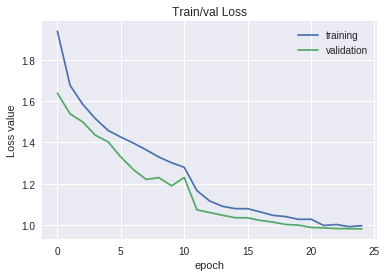

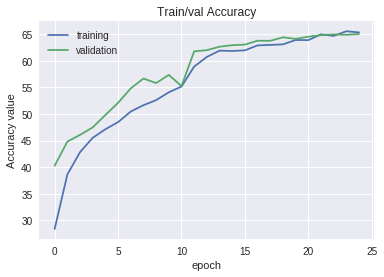

In [46]:
# Your code for training
nb_epochs = 25

cnn_trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

cnn = ConvNet()
cnn.to(device)
cnn_optimizer = torch.optim.Adam(cnn.parameters(),
                                 lr=0.001,
                                 weight_decay=0.004)
cnn_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=cnn_optimizer,
                                                step_size=10,
                                                gamma=0.1) 
cnn_loss_function = nn.CrossEntropyLoss()


stats_training = trainer.fit(cnn,
                             train_loader,
                             val_loader,
                             cnn_optimizer,
                             cnn_loss_function,
                             scheduler=cnn_scheduler)

plot_stats(stats_training)

## 5. Evaluate on test set
Evaluate your best MLP model and your trained ConvNet model on the test set. Report the test accuracy on both models.

In [47]:
_, mlp_acc = cnn_trainer.validation(best_model, test_loader, cnn_loss_function)
_, cnn_acc = cnn_trainer.validation(cnn, test_loader, cnn_loss_function)

print(f'MLP accuracy: {mlp_acc:.2f}%, CNN accuracy: {cnn_acc}%')

MLP accuracy: 51.70%, CNN accuracy: 66.4%
